### Import

In [ ]:
import importlib
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison

In [ ]:
import os

# Set the CUBLAS_WORKSPACE_CONFIG environment variable
# The error message suggests :4096:8 or :16:8. The first is generally preferred.
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

## Display function

In [ ]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by='fpr').reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Best ROC envelope

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve

def get_best_roc_envelope(results_list, results_original_roc=None):
    """
    Constructs the upper envelope of multiple ROC curves to find the best
    possible operating points from a collection of classifiers.

    This function is guaranteed to produce a list of points that starts at
    (FPR=0, TPR=0) and ends at (FPR=1, TPR=1), making it suitable for direct
    plotting and AUC calculation.

    Args:
        results_list (list): A list of dictionaries. Each dictionary must
                             contain a 'model' name and the full ROC results
                             under the 'full_roc' key.
        results_original_roc (dict, optional): A dictionary containing the
                                               ROC results of a baseline model,
                                               which will also be included in
                                               the comparison. Defaults to None.

    Returns:
        list: A sorted list of dictionaries representing the optimal ROC
              envelope. Each dictionary includes 'model', 'fpr', 'tpr',
              and 'threshold'.
    """
    all_points = []

    # Step 1: Gather all ROC points from all provided models
    all_results = results_list[:]
    if results_original_roc:
        all_results.append({
            'model': 'original_baseline',
            'full_roc': results_original_roc
        })

    for result in all_results:
        model_name = result.get('model', 'Unknown Model')
        roc = result.get('full_roc')
        if not roc: continue

        fprs = roc.get('fpr', [])
        tprs = roc.get('tpr', [])
        thresholds = roc.get('thresholds', [])

        for i in range(len(fprs)):
            threshold = thresholds[i] if i < len(thresholds) else thresholds[-1]
            all_points.append({
                'model': model_name, 'fpr': fprs[i],
                'tpr': tprs[i], 'threshold': threshold
            })

    # Handle case with no data by returning a default diagonal line
    if not all_points:
        return [
            {'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf},
            {'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0}
        ]

    # Step 2: Sort all points by FPR (asc), then by TPR (desc)
    all_points.sort(key=lambda p: (p['fpr'], -p['tpr']))

    # Step 3: Build the core ROC envelope
    best_roc_envelope = []
    max_tpr_so_far = -1.0
    for point in all_points:
        # Add a point only if it has a strictly higher TPR
        if point['tpr'] > max_tpr_so_far:
            # To prevent adding multiple points at the same FPR, check if the last point
            # has the same FPR and replace it if so (since this one has a higher TPR)
            if best_roc_envelope and best_roc_envelope[-1]['fpr'] == point['fpr']:
                best_roc_envelope[-1] = point
            else:
                best_roc_envelope.append(point)
            max_tpr_so_far = point['tpr']
    
    # Step 4: Manually add extremities if they are missing
    
    # Ensure the curve starts at (0, 0)
    if not best_roc_envelope or best_roc_envelope[0]['fpr'] > 0.0:
        best_roc_envelope.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if best_roc_envelope[-1]['fpr'] < 1.0 or best_roc_envelope[-1]['tpr'] < 1.0:
        best_roc_envelope.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return best_roc_envelope

## Data generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )

        

        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )


        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    return train_data, test_data, val_data


## Calculate Statistics function

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test, threshold=0.5):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        y_prob = clf_model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification_rate = 1 - accuracy

        return {"fpr": fpr, "tpr": tpr, "precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy, "misclassification_rate": misclassification_rate}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





## PneumoniaMNIST: NN

In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

In [2]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4
K_FOLDS = 4

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes, image_height, image_width):
        super(SimpleCNN, self).__init__()
        #Convoluional layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 224x224 -> 112x112
        
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 112x112 -> 56x56
        
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 56x56 -> 28x28
        
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 28x28 -> 14x14
        )

        # --- DYNAMIC FLATTENED SIZE CALCULATION ---
        # Create a dummy tensor with the specified input dimensions
        dummy_input = torch.randn(1, in_channels, image_height, image_width)
        # Pass it through the feature extractor to see the output shape
        dummy_output = self.features(dummy_input)
        # The number of elements in the output tensor is our flattened size
        self.flattened_size = dummy_output.numel()

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.relu_fc = nn.ReLU()
        # Output layer: num_classes=1 for binary classification (outputting logits)
        self.fc2 = nn.Linear(512, num_classes)

    def extract_features(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = self.fc1(x)
        x = self.relu_fc(x)
        return x

    def forward(self, x):
        x = self.extract_features(x)
        x = self.fc2(x)
        return x

### Lightning module

In [4]:
import torchmetrics
import pytorch_lightning as pl

class LitSimpleCNN(pl.LightningModule):
    def __init__(self, in_channels, num_classes, learning_rate, image_height, image_width, training_mode='full_network'):
        super().__init__()
        # Save hyperparameters
        self.save_hyperparameters()
        
        # Define the model
        self.model = SimpleCNN(
            in_channels=self.hparams.in_channels, 
            num_classes=self.hparams.num_classes,
            image_height=self.hparams.image_height,
            image_width=self.hparams.image_width
        )
        
        # Define loss function
        self.criterion = nn.BCEWithLogitsLoss()

        # Define metrics
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.val_accuracy = torchmetrics.Accuracy(task="binary")
        self.val_auc = torchmetrics.AUROC(task="binary")

        self.test_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_auc = torchmetrics.AUROC(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary")
        self.test_recall = torchmetrics.Recall(task="binary")
        self.test_f1 = torchmetrics.F1Score(task="binary")

        # This list will store outputs from each test step
        self.last_test_results = {}
        self.test_step_outputs = []


    def forward(self, x):
        return self.model(x)
    
    def freeze_feature_extractor(self):
        print("Freezing feature extractor layers...")
        for param in self.model.features.parameters():
            param.requires_grad = False
        for param in self.model.fc1.parameters():
            param.requires_grad = False

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        # For BCEWithLogitsLoss, labels must be float
        labels = labels.float()
        
        outputs = self(inputs) # Forward pass
        loss = self.criterion(outputs, labels)

        # We need to handle which part of the network we are training
        if self.hparams.training_mode == 'full_network':
            self.log('train_loss_full', loss)
        elif self.hparams.training_mode == 'classifier_only':
            self.log('train_loss_classifier', loss)
        
        # Log metrics
        self.train_accuracy(outputs, labels.int())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('train_acc', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        labels = labels.float()
        
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        
        # Log metrics
        self.val_accuracy(outputs, labels.int())
        self.val_auc(outputs, labels.int())
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('val_acc', self.val_accuracy, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('val_auc', self.val_auc, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels.float())
        
        # Append predictions and labels to our list
        self.test_step_outputs.append({"preds": outputs.detach(), "labels": labels.detach()})
        
        # Log the loss for this batch
        self.log('test_loss', loss)
        return {"loss": loss}

    def on_test_epoch_end(self):
        # Concatenate all predictions and labels from the list we built
        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs])

        # Calculate final metrics over the entire test set
        test_acc = self.test_accuracy(all_preds, all_labels.int())
        test_auc_val = self.test_auc(all_preds, all_labels.int())
        test_prec = self.test_precision(all_preds, all_labels.int())
        test_rec = self.test_recall(all_preds, all_labels.int())
        test_f1_val = self.test_f1(all_preds, all_labels.int())
        test_cm_val = torchmetrics.functional.confusion_matrix(all_preds, all_labels.int(), task="binary")

        # Log the final metrics
        self.log("test_acc_epoch", test_acc)
        self.log("test_auc_epoch", test_auc_val)

        print(f"\n--- Final Test Metrics ---")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"AUC: {test_auc_val:.4f}")
        print(f"Precision: {test_prec:.4f}")
        print(f"Recall: {test_rec:.4f}")
        print(f"F1-Score: {test_f1_val:.4f}")
        print(f"Confusion Matrix:\n{test_cm_val}")
        print("--------------------------\n")

        # Calculate data for the ROC Curve
        fpr, tpr, thresholds = torchmetrics.functional.roc(
            torch.sigmoid(all_preds),
            all_labels.int(),
            task="binary"
        )

        # Store the results to be retrieved later in the main script
        self.last_test_results = {
            "fpr": fpr.cpu(),
            "tpr": tpr.cpu(),
            "auc": test_auc_val,
            "f1": test_f1_val,
            "precision": test_prec,
            "recall": test_rec,
            "cm": test_cm_val,
            "thresholds": thresholds.cpu(),
        }
        # Free up memory
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer
    
    def extract_features_from_dataloader(self, dataloader):
        """
        Extracts features and corresponding labels from a given dataloader.

        Args:
            dataloader (torch.utils.data.DataLoader): The dataloader to process.

        Returns:
            tuple: A tuple containing:
                - torch.Tensor: A tensor of all extracted features.
                - torch.Tensor: A tensor of all corresponding labels.
        """
        # Set the model to evaluation mode to disable dropout, batch norm updates, etc.
        self.model.eval()
        
        all_features = []
        all_labels = []

        # Disable gradient calculations for efficiency
        with torch.no_grad():
            for inputs, labels in dataloader:
                # Move inputs to the same device as the model
                inputs = inputs.to(self.device)
                
                # Use the feature extraction method from the underlying SimpleCNN
                features = self.model.extract_features(inputs)
                
                # Append the results to our lists. Move to CPU to avoid filling up GPU memory.
                all_features.append(features.cpu())
                all_labels.append(labels.cpu())

        # Concatenate all the collected batches into single tensors
        final_features = torch.cat(all_features, dim=0)
        final_labels = torch.cat(all_labels, dim=0)

        # It's good practice to set the model back to train mode if you plan to continue training
        self.model.train()
        
        return final_features, final_labels

### Classifier only

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import torchmetrics
import numpy as np

# A simple classifier head
class SimpleClassifier(nn.Module):
    def __init__(self, input_features=512, num_classes=1):
        super().__init__()
        self.output_layer = nn.Linear(input_features, num_classes)

    def forward(self, x):
        return self.output_layer(x)

# A new LightningModule just for training the classifier
class LitClassifier(pl.LightningModule):
    def __init__(self, input_features=512, num_classes=1, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = SimpleClassifier(input_features, num_classes)
        self.criterion = nn.BCEWithLogitsLoss()
        
        # --- METRICS ---
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_auc = torchmetrics.AUROC(task="binary")
        
        # This list will store outputs from each test step
        self.test_step_outputs = []
        # This dictionary will hold the final results
        self.last_test_results = {}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self(features)
        
        # For the loss function, labels need to be reshaped to match outputs
        loss = self.criterion(outputs, labels.float().view(-1, 1))
        
        # For metrics, squeeze predictions to match labels' shape
        self.train_accuracy(outputs.squeeze(), labels.squeeze().int())
        
        self.log('classifier_train_loss', loss, on_step=False, on_epoch=True)
        self.log('classifier_train_acc', self.train_accuracy, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self.model(features)
        loss = self.criterion(outputs, labels.float().view(-1, 1))

        # Append predictions and labels to our list for aggregation
        self.test_step_outputs.append({"preds": outputs.detach(), "labels": labels.detach()})
        
        self.log('test_loss', loss)
        return {"loss": loss}

    def on_test_epoch_end(self):
        if not self.test_step_outputs:
            return # Avoid errors if test loop was empty

        # Concatenate all predictions and labels
        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs])

        # --- FIX: Squeeze BOTH predictions and labels to ensure they match ---
        squeezed_preds = all_preds.squeeze()
        all_probs = torch.sigmoid(squeezed_preds)
        # The labels tensor might also be [N, 1], so we squeeze it as well.
        int_labels = all_labels.squeeze().int()

        # Calculate final scalar metrics
        test_acc = self.test_accuracy(squeezed_preds, int_labels)
        test_auc_val = self.test_auc(squeezed_preds, int_labels)


        # Get the confusion matrix stats at the default 0.0 logit threshold
        tp, fp, tn, fn, _ = torchmetrics.functional.stat_scores(
            all_probs, int_labels, task="binary", threshold=0.5
        ) 
        
        # Calculate TPR and FPR from these raw scores
        epsilon = 1e-6
        tpr_at_0 = tp / (tp + fn + epsilon)
        fpr_at_0 = fp / (fp + tn + epsilon)

        # Calculate data for the full ROC Curve
        fpr_full, tpr_full, thresholds_full = torchmetrics.functional.roc(
            torch.sigmoid(squeezed_preds),
            int_labels,
            task="binary"
        )




        print(f"\n--- Final Classifier Test Metrics ---")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"AUC: {test_auc_val:.4f}")
        print("-------------------------------------\n")
        
        self.last_test_results = {
            "w": self.hparams.get('w'),
            "fpr": fpr_at_0.cpu().numpy(),
            "tpr": tpr_at_0.cpu().numpy(),
            "threshold": 0.5,
            "auc": test_auc_val.cpu().numpy(),
            "accuracy": test_acc.cpu().numpy(),
            "full_roc": {
                "fpr": fpr_full.cpu().numpy(),
                "tpr": tpr_full.cpu().numpy(),
                "thresholds": thresholds_full.cpu().numpy()
            }
        }
        self.test_step_outputs.clear()
        
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)


### Generate data

In [ ]:
from sklearn.model_selection import KFold
train_dataset, test_dataset, val_dataset = generate_data("pneumoniaMNIST")

# Ensure you have your train_loader and val_loader defined here
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset.transform = data_transforms
test_dataset.transform = data_transforms
val_dataset.transform = data_transforms


train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
#new_train_loader = data.DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) to be done inside the sample_ratio loop
test_loader = data.DataLoader(test_dataset, batch_size=int(BATCH_SIZE/4), shuffle=False, num_workers=NUM_WORKERS)
val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# initialize fold
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)
best_model_paths = [] # List to store the path of the best model from each stage

# 1. Instantiate the LightningModule
model = LitSimpleCNN(
    in_channels=NUM_CHANNELS,
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE,
    training_mode='full_network',  # Change to 'classifier_only' if you want to train only the classifier
    image_height=IMAGE_SIZE,
    image_width=IMAGE_SIZE
)

# Optional: Print model summary
# You need to move the model to a device first for torchsummary to work
# summary(model.to('cuda'), (NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))
# model.to('cpu') # Move it back if needed

checkpoint_callback_full_model = ModelCheckpoint(
    monitor='val_acc',
    dirpath='checkpoints/',
    filename='simple-cnn-full-{epoch:02d}-{val_acc:.2f}',
    save_top_k=1,
    mode='max',
)

train_trainer_1 = pl.Trainer(
    accelerator='gpu',                 # Use GPUs
    devices=1,                         # Number of GPUs to use
    #strategy='ddp_notebook',                    # DistributedDataParallel strategy (best for multi-GPU)
    max_epochs=NUM_EPOCHS,              # Total number of epochs
    callbacks=[checkpoint_callback_full_model, progress_bar],
    logger=pl.loggers.TensorBoardLogger("lightning_logs/", name="simple_cnn-full")
)

test_trainer_1 = pl.Trainer(
    accelerator='gpu',
    devices=1,  # Use only one GPU
    logger = pl.loggers.TensorBoardLogger("lightning_logs/", name="simple_cnn_test"),
    # Add the callback here so the Trainer can find the 'best' path
    callbacks=[checkpoint_callback_full_model],
    precision='16-mixed'  # Use mixed precision for testing
)


# --- Phase 1 Training ---
print(f"--- Starting Training for {NUM_EPOCHS} epochs on train_loader ---")
train_trainer_1.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# CRITICAL: Save the path to the best model from this phase
path_after_phase1 = checkpoint_callback_full_model.best_model_path
print(f"Best model from Phase 1 saved to: {path_after_phase1}")

# --- Test 1: Evaluate the model from after Phase 1 ---
print(f"\n--- Testing model from Phase 1 checkpoint: {path_after_phase1} ---")
model.current_test_title = "ROC Curve after training on DataLoader 1"
model = LitSimpleCNN.load_from_checkpoint(path_after_phase1)  # Load the model from Phase 1
model.eval().to('cuda:0')  # Ensure the model is in evaluation mode and on GPU
test_trainer_1.test(model, dataloaders=test_loader, ckpt_path=path_after_phase1)
results_phase1 = model.last_test_results.copy()
results_original_roc = {"fpr": results_phase1["fpr"], "tpr": results_phase1["tpr"], "thresholds": results_phase1["thresholds"], "name": "Original NN PneumoniaMNIST", "auc": results_phase1["auc"], "model": model}

#------ Extract features from the training set for Phase 1 ------
training_features, training_labels = model.extract_features_from_dataloader(train_loader)
print(f"Extracted features shape: {training_features.shape}")
print(f"Extracted labels shape: {training_labels.shape}")

#------Extract features from the testing set for Phase 1 ------
testing_features, testing_labels = model.extract_features_from_dataloader(test_loader)
print(f"Extracted testing features shape: {testing_features.shape}")
print(f"Extracted testing labels shape: {testing_labels.shape}")

### Oversample

In [ ]:
import numpy as np
from collections import Counter

# --- Configuration ---
EPSILON = 1e-9
SIGMA_KDE_PERTURBATION = 0.1 # Adjust as needed

def generate_ratios(train_data):
    """
    Generates a list of target class ratios for an experiment.
    """
    # --- Initial Data Analysis ---
    # FIX: Convert each numpy array label to a standard Python number using .item()
    # This makes the labels hashable for the Counter.
    labels = [item[1].item() for item in train_data]

    # Now use the list of labels with the Counter
    counter = Counter(labels)
    Class0_initial = counter.get(0, 0)
    Class1_initial = counter.get(1, 0)

    # --- Generate Target Ratios ---
    class_ratio_low = 0.1
    class_ratio_high = 10.0
    num_points_below = 10
    num_points_above = 10

    if Class1_initial == 0 and Class0_initial == 0:
        print("ERROR: Both classes have zero samples initially. Cannot proceed.")
        alpha_target_actual_values = []
        current_class_ratio = 1.0
    elif Class1_initial == 0:
        current_class_ratio = np.inf
    else:
        current_class_ratio = Class0_initial / Class1_initial

    alpha_target_list = []
    if Class0_initial > 0 or Class1_initial > 0:
        if current_class_ratio > 0 and not np.isinf(current_class_ratio):
            alpha_target_list.append(current_class_ratio)
        _safe_class_ratio_low = max(class_ratio_low, EPSILON)
        if current_class_ratio > _safe_class_ratio_low and not np.isinf(current_class_ratio):
            try:
                alpha_b = np.geomspace(_safe_class_ratio_low, current_class_ratio, num_points_below, endpoint=False)
                alpha_target_list.extend(alpha_b)
            except ValueError: pass
        if current_class_ratio < class_ratio_high and current_class_ratio >= 0 and not np.isinf(current_class_ratio):
            try:
                _start_geom_above = max(current_class_ratio, _safe_class_ratio_low)
                if class_ratio_high > _start_geom_above:
                    alpha_a = np.geomspace(_start_geom_above, class_ratio_high, num_points_above, endpoint=True)
                    if not np.isclose(_start_geom_above, current_class_ratio) and current_class_ratio >=_safe_class_ratio_low and current_class_ratio <= class_ratio_high :
                        alpha_target_list.append(current_class_ratio)
                    alpha_target_list.extend(alpha_a)
                elif np.isclose(class_ratio_high, _start_geom_above):
                    alpha_target_list.append(class_ratio_high)
            except ValueError: pass
        if not alpha_target_list and (Class0_initial > 0 or Class1_initial > 0):
            if not np.isinf(current_class_ratio) and current_class_ratio > 0:
                alpha_target_list.append(current_class_ratio)
            else:
                alpha_target_list.extend(np.geomspace(_safe_class_ratio_low, class_ratio_high, num_points_below + num_points_above))
        alpha_target_actual_values = np.unique(alpha_target_list)
        alpha_target_actual_values = np.sort(alpha_target_actual_values[alpha_target_actual_values >= 0])
        alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values >= _safe_class_ratio_low]
        alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values <= class_ratio_high]
        if not alpha_target_actual_values.size and (Class0_initial > 0 or Class1_initial > 0) :
            if not np.isinf(current_class_ratio) and current_class_ratio > _safe_class_ratio_low and current_class_ratio < class_ratio_high:
                alpha_target_actual_values = np.array([current_class_ratio])
            else:
                alpha_target_actual_values = np.array([(_safe_class_ratio_low + class_ratio_high)/2.0])


    print(f"INFO: Initial C0={Class0_initial}, C1={Class1_initial}, Ratio(0/1): {current_class_ratio if Class1_initial > 0 else 'N/A'}")
    print(f"INFO: Target ratios (w values): {alpha_target_actual_values}")
    print(f"INFO: KDE-like perturbation sigma: {SIGMA_KDE_PERTURBATION}")
    print(f"INFO: Standard deviation of synthetic samples will NOT be modified after generation.")

    return alpha_target_actual_values, Class0_initial, Class1_initial

In [ ]:
import torch
import numpy as np
from collections import Counter

def oversample_with_KDE(
    training_features,
    training_labels,
    alpha_target,
    sigma_perturbation,
    epsilon=1e-9
):
    """
    Oversamples a dataset by generating synthetic samples via noise injection (jittering)
    and combines them with the original data.

    This function is self-contained and does not rely on global variables.

    Args:
        training_features (torch.Tensor): Feature vectors of the original training set.
        training_labels (torch.Tensor): Labels of the original training set.
        alpha_target (float): The desired target ratio of (Class 0 / Class 1).
        sigma_perturbation (float): Std deviation of the Gaussian noise to add.
        epsilon (float): A small value to prevent division by zero.

    Returns:
        tuple: A tuple containing (X_resampled, y_resampled) as new torch tensors.
    """
    # --- 1. Initial Analysis (now done inside the function) ---
    counter = Counter(training_labels.squeeze().tolist())
    Class0_initial = counter.get(0, 0)
    Class1_initial = counter.get(1, 0)

    # This calculation must also be inside the function
    if Class1_initial == 0 and Class0_initial == 0:
        print("  WARN: Both classes are empty. Returning original (empty) dataset.")
        return training_features, training_labels
    elif Class1_initial == 0:
        current_class_ratio = np.inf
    else:
        current_class_ratio = Class0_initial / Class1_initial

    # --- 2. Determine Oversampling Strategy ---
    oversampled_class_label = -1
    num_to_generate = 0

    if alpha_target < current_class_ratio:
        # To decrease the ratio (C0/C1), we must INCREASE C1.
        oversampled_class_label = 1
        if alpha_target > epsilon:
            final_count = int(round(Class0_initial / alpha_target))
            num_to_generate = final_count - Class1_initial
    else: # This covers alpha_target >= current_class_ratio
        # To increase the ratio (C0/C1), we must INCREASE C0.
        oversampled_class_label = 0
        final_count = int(round(Class1_initial * alpha_target))
        num_to_generate = final_count - Class0_initial

    if num_to_generate <= 0:
        # This handles no-op cases cleanly
        print(f"  INFO: For w={alpha_target:.4f}, no new samples to generate. Returning original dataset.")
        return training_features, training_labels

    # --- 3. Generate Synthetic Samples ---
    print(f"  INFO: Strategy: Oversample class {oversampled_class_label} by generating {num_to_generate} new samples.")
    
    original_features_np = training_features.numpy()
    original_labels_np = training_labels.squeeze().numpy()
    
    indices_class = np.where(original_labels_np == oversampled_class_label)[0]

    if len(indices_class) == 0:
        print(f"  WARN: Cannot oversample class {oversampled_class_label} as it has no initial samples. Returning original dataset.")
        return training_features, training_labels

    seed_features = original_features_np[indices_class]
    
    # Generate new samples by adding noise
    new_features_list = [seed_features[_] + np.random.randn(*seed_features.shape[1:])*sigma_perturbation for _ in np.random.choice(len(seed_features), size=num_to_generate, replace=True)]
    new_features_np = np.array(new_features_list)
    new_labels_np = np.full(num_to_generate, oversampled_class_label)

    # --- 4. Combine and Return ---
    X_resampled = np.vstack([original_features_np, new_features_np])
    y_resampled = np.hstack([original_labels_np, new_labels_np])

    return torch.tensor(X_resampled, dtype=torch.float32), torch.tensor(y_resampled, dtype=torch.long)


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np
from sklearn.metrics import confusion_matrix

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)

#store the weighted classifiers of all the folds
list_folds_weighted_clfs = []  # List to store classifiers from all folds
#store the best classfiers of all the folds
list_folds_best_models = []  # List to store best models from all folds

# Dictionary to store the history of each fold
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

test_feature_dataset = data.TensorDataset(testing_features, testing_labels)
test_feature_loader = data.DataLoader(test_feature_dataset, batch_size=int(BATCH_SIZE), num_workers=NUM_WORKERS)

train_feature_dataset = data.TensorDataset(training_features, training_labels)

# 3. K-fold cross-validation loop
for fold, (train_ids, val_ids) in enumerate(kfold.split(training_features)):
    list_weighted_clfs = [] # List to store the models trained at each stage
    best_clfs = [] # List to store the best models from each stage
    best_model_paths = [] # List to store the path of the best model from each stage

    # Instantiate our new, simple classifier
    classifier_model = LitClassifier(learning_rate=LEARNING_RATE)
 
    print(f"--- Starting Fold {fold + 1}/{K_FOLDS} ---")

    # --- Create datasets and dataloaders for the current fold ---
    # FIX 2: Get the fold-specific data by indexing the original tensors
    fold_train_features, fold_train_labels = training_features[train_ids], training_labels[train_ids]
    fold_val_features, fold_val_labels = training_features[val_ids], training_labels[val_ids]

    # Create the validation loader for this fold
    fold_val_dataset = data.TensorDataset(fold_val_features, fold_val_labels)
    fold_loader = data.DataLoader(fold_val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    # Create a temporary dataset for the generate_ratios function
    temp_train_dataset_for_ratios = data.TensorDataset(fold_train_features, fold_train_labels)
    alpha_target_actual_values, Class0_initial, Class1_initial = generate_ratios(train_data=temp_train_dataset_for_ratios)

  
    for w_idx, w in enumerate(alpha_target_actual_values):
        print(f"\n--- Processing target ratio w ({w_idx+1}/{len(alpha_target_actual_values)}): {w:.4f} ---")
        
        #oversample
        X_resampled, y_resampled = oversample_with_KDE(
            fold_train_features,      # Pass features as an argument
            fold_train_labels,        # Pass labels as an argument
            alpha_target=w,
            sigma_perturbation=SIGMA_KDE_PERTURBATION
        )

        

        # create the balanced_feature_dataset
        balanced_feature_dataset = data.TensorDataset(X_resampled, y_resampled)
        balanced_feature_loader = data.DataLoader(balanced_feature_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

        # A simpler approach is to fine-tune the original model
        print("\n--- Starting Second Stage Training (Classifier Only) ---")

        

        checkpoint_callback = ModelCheckpoint(
            dirpath=f'checkpoints/stage_{w_idx+1}/',
            filename=f'best-model-{{epoch:02d}}-{{w:.2f}}',
            save_top_k=1,
            mode='max',
        )

        trainer_classifier = pl.Trainer(
            accelerator='gpu',
            devices=1,
            max_epochs=1,
            callbacks=[checkpoint_callback, progress_bar],
            deterministic=True
        )

        trainer_classifier.fit(classifier_model, train_dataloaders=balanced_feature_loader)

        # 5. Get the path to the best model from THIS stage and store it
        if checkpoint_callback.best_model_path:
            best_path_this_stage = checkpoint_callback.best_model_path
            print(f"--- Stage {w_idx+1} complete. Best model path: {best_path_this_stage} ---")
            best_model_paths.append(best_path_this_stage)
            
            # 6. CRITICAL: Load the best weights back into the model object
            # This ensures we carry forward the BEST model to the next stage, not the last.
            print(f"Loading best weights from {best_path_this_stage} to continue...")
            classifier_model = LitClassifier.load_from_checkpoint(best_path_this_stage, strict=False)  # Use strict=False to ignore missing keys if any
        else:
            print(f"--- Stage {i+1} complete. No checkpoint was saved. ---")
            # If no checkpoint was saved, the model object will just have the weights from the last epoch.
        

    # Loop through each saved model checkpoint
    for i, checkpoint_path in enumerate(best_model_paths):
        print(f"\n--- Testing model from checkpoint: {checkpoint_path} ---")

        # 1. Load the PyTorch model from the checkpoint
        pytorch_model = LitClassifier.load_from_checkpoint(checkpoint_path, strict=False)
        pytorch_model.eval()  # Set model to evaluation mode
        pytorch_model.to('cuda:0') # Move model to GPU

        # --- Generate Predictions for the ENTIRE test set ---
        # We will collect the raw model outputs (logits) and true labels
        all_logits = []
        all_labels = []

        # Wrap the loop in torch.no_grad() for efficiency
        with torch.no_grad():
            for batch in tqdm(fold_loader, desc=f"Predicting with model {i+1}"):
                inputs, labels = batch
                
                # Move data to the GPU
                inputs = inputs.to('cuda:0')
                
                # Get model output (raw logits) for the batch
                logits = pytorch_model(inputs)
                
                # Append batch results to lists (move back to CPU to prevent GPU memory buildup)
                all_logits.append(logits.cpu())
                all_labels.append(labels.cpu())

        # Concatenate all batch results into single tensors
        # These now contain the predictions and labels for the full test set
        full_dataset_logits = torch.cat(all_logits)
        full_dataset_labels = torch.cat(all_labels).int() # Ensure labels are integers

        # --- Now, Calculate ALL Metrics using the generated predictions ---

        # 2. Calculate the full ROC curve data
        # Use the raw logits, torchmetrics will handle applying all thresholds
        array_of_all_fprs, array_of_all_tprs, threshold_vals = torchmetrics.functional.roc(
            preds=full_dataset_logits,
            target=full_dataset_labels,
            task="binary"
        )

        # 3. Calculate confusion matrix based on a hard threshold (e.g., 0.5)
        # Note: The model outputs logits, so the threshold 0.5 for probabilities corresponds to 0.0 for logits.
        hard_preds = (full_dataset_logits > 0.0).int().numpy()
        tn, fp, fn, tp = confusion_matrix(full_dataset_labels.numpy(), hard_preds).ravel()

        # 4. Calculate metrics from the confusion matrix
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # This is also Recall
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * tpr) / (precision + tpr) if (precision + tpr) > 0 else 0
        
        print(f"Results at threshold 0.5: TPR={tpr:.4f}, FPR={fpr:.4f}, F1-Score={f1:.4f}")
        
        # 5. Store the comprehensive results for this model
        list_weighted_clfs.append({
            "fpr": fpr,
            "tpr": tpr,
            "model": pytorch_model, 
            "threshold": 0.5,
            "full_roc": {
                "fpr": array_of_all_fprs,
                "tpr": array_of_all_tprs,
                "thresholds": threshold_vals
            }
        })
        best_clfs = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
    list_folds_weighted_clfs.append(list_weighted_clfs)
    list_folds_best_models.append(best_clfs)


In [ ]:
# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
plot_roc_comparison(
    results_lists=results_lists,
    names=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4"],
    results_original_roc=results_original_roc
)

### Extract features on test set and create 

In [ ]:
test_features, test_labels = model.extract_features_from_dataloader(test_loader)
print(f"Extracted test features shape: {test_features.shape}")
print(f"Extracted test labels shape: {test_labels.shape}")
# Create dataloader for the test features
test_feature_dataset = data.TensorDataset(test_features, test_labels)
test_feature_loader = data.DataLoader(test_feature_dataset, batch_size=int(BATCH_SIZE), num_workers=NUM_WORKERS)

In [ ]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Save the data
save_to_pickle(list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_feature_loader, filename='pickle/medMNIST_oversampling.pkl')




# Load pickle

In [6]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Load the data
list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader = load_from_pickle(filename='pickle/medMNIST_oversampling.pkl')

Data loaded successfully.


### Ensemble prediction using voting

In [7]:
import numpy as np

# --- Loop through all the FPR values to generate the ensemble ROC curve ---



results_tuple, prior_proba = predict_ensemble_and_evaluate(list_folds_best_models=list_folds_best_models,
    test_loader=test_loader)

ensemble_results_soft = results_tuple['soft_voting']
ensemble_results_hard = results_tuple['hard_voting']
misclassification_risk = results_tuple['misclassification_risk']






Creating a single ensemble from 180 models across all folds.
Extracting full dataset...
Getting predictions from all models...


## Neyman Pearson ROC curve

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
BATCH_SIZE = 64

class SklearnPyTorchCNNWrapper:
    def __init__(self, model, epochs=5, lr=0.001, image_dims=(1, 224, 224)):
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.image_dims = image_dims
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)

    def fit(self, X, y):
        self.model.train()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.BCEWithLogitsLoss()

        dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).view(-1, 1))
        loader = DataLoader(dataset, batch_size=32, shuffle=True)

        print("Starting PyTorch model training inside wrapper...")
        for epoch in range(self.epochs):
            for inputs, labels in loader:
                inputs = inputs.view(-1, *self.image_dims).to(self.device)
                labels = labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            print(f"Epoch {epoch+1}/{self.epochs}, Loss: {loss.item():.4f}")
        return self

    def predict_proba(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)
            all_probs = []
            for i in range(0, len(X_tensor), BATCH_SIZE):
                batch = X_tensor[i:i+BATCH_SIZE]
                batch = batch.view(-1, *self.image_dims).to(self.device)
                prob_class_1_batch = self.model(batch).cpu().numpy()
                all_probs.append(prob_class_1_batch)
            
            prob_class_1 = np.vstack(all_probs)
            prob_class_0 = 1 - prob_class_1
            
            return np.hstack((prob_class_0, prob_class_1))

In [18]:
import os
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, auc
import numpy as np
import torch
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from nproc import npc
from sklearn.ensemble import RandomForestClassifier


# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4

train_dataset, test_dataset, val_dataset = generate_data("pneumoniaMNIST")


# Ensure you have your train_loader and val_loader defined here
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset.transform = data_transforms
test_dataset.transform = data_transforms
val_dataset.transform = data_transforms


train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
#new_train_loader = data.DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) to be done inside the sample_ratio loop
test_loader = data.DataLoader(test_dataset, batch_size=int(BATCH_SIZE/4), shuffle=False, num_workers=NUM_WORKERS)
val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

def flatten_dataset(dataset):
    X_list, y_list = [], []
    for img, label in dataset:
        X_list.append(np.array(img).flatten())
        y_list.append(label[0])
    return np.array(X_list), np.array(y_list)

X_train, y_train = flatten_dataset(train_dataset)
X_test, y_test = flatten_dataset(test_dataset)

print("Generating constrained ROC curve (Neyman-Pearson Simulation)...")

npc_instance = npc()

# 1. Instantiate your PyTorch model
pytorch_cnn = SimpleCNN(
    in_channels=NUM_CHANNELS,
    num_classes=1,
    image_height=IMAGE_SIZE,
    image_width=IMAGE_SIZE
)
wrapped_model = SklearnPyTorchCNNWrapper(
    model=pytorch_cnn, 
    epochs=NUM_EPOCHS, 
    lr=LEARNING_RATE, 
    image_dims=(NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
)

result = npc_instance.npc(
    x=X_train, 
    y=y_train, 
    method="", # Leave blank to use the provided model
    model=wrapped_model
)

# Extract the results from the single run
fit_results = result[0][0]
final_model = fit_results[0]             # The single trained model object
y_calib_labels = fit_results[1]          # The labels from the internal calibration set
y_calib_scores = fit_results[2]          # The model's scores on the calibration set
initial_sign = fit_results[4]
print("Phase 1 Complete.")

# --- 5. Phase 2: Evaluate on the HELD-OUT Test Set ---
print("\nPhase 2: Evaluating on the unseen test set...")
alphas = np.linspace(0, 1, 51)
roc_points = []

# Get the model's scores on the completely separate test set
y_test_scores = final_model.predict_proba(X_test)[:, 1]

# The sign must be consistent between calibration and testing
if initial_sign:
    y_calib_scores = -y_calib_scores
    y_test_scores = -y_test_scores

for i, alpha in enumerate(alphas):
    # Use the CALIBRATION data to find the optimal cutoff for this alpha
    core_result = npc_instance.npc_core(y_calib_labels, y_calib_scores, alpha, 0.05, 1)
    if not core_result or core_result[6]: continue
    
    cutoff = core_result[0]
    
    # Apply that cutoff to the TEST data scores to get final predictions
    y_pred_test = (y_test_scores >= cutoff).astype(int)
    
    # Calculate performance on the TEST data
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
    current_fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    current_tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    roc_points.append({'fpr': current_fpr, 'tpr': current_tpr})
    print(f"Alpha {alpha:.2f} ({i+1}/{len(alphas)}): FPR={current_fpr:.3f}, TPR={current_tpr:.3f}")

# --- 4. Process and Plot the Results ---
# Remove duplicate points
unique_points_dict = {(p['fpr'], p['tpr']): p for p in roc_points}
constrained_points = list(unique_points_dict.values())
constrained_points = sorted(constrained_points, key=lambda x: x['fpr'])

# ensure 0,0 and 1,1 are included
if constrained_points[0]['fpr'] > 0:
    constrained_points.insert(0, {'fpr': 0.0, 'tpr': 0.0})
if constrained_points[-1]['fpr'] < 1:
    constrained_points.append({'fpr': 1.0, 'tpr': 1.0})

3.0.2
Number of training samples: 4708
Number of test samples: 624
Number of validation samples: 524


/tmp/ipykernel_127530/1880074977.py:43: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_list.append(np.array(img).flatten())


Generating constrained ROC curve (Neyman-Pearson Simulation)...
Starting PyTorch model training inside wrapper...
Epoch 1/1, Loss: 0.0094
Phase 1 Complete.

Phase 2: Evaluating on the unseen test set...
Sample size is too small for the given alpha. Try a larger alpha.
Alpha 0.02 (2/51): FPR=0.111, TPR=0.723
Alpha 0.04 (3/51): FPR=0.222, TPR=0.892
Alpha 0.06 (4/51): FPR=0.316, TPR=0.936
Alpha 0.08 (5/51): FPR=0.380, TPR=0.951
Alpha 0.10 (6/51): FPR=0.436, TPR=0.974
Alpha 0.12 (7/51): FPR=0.470, TPR=0.987
Alpha 0.14 (8/51): FPR=0.547, TPR=0.987
Alpha 0.16 (9/51): FPR=0.590, TPR=0.990
Alpha 0.18 (10/51): FPR=0.607, TPR=0.990
Alpha 0.20 (11/51): FPR=0.620, TPR=0.992
Alpha 0.22 (12/51): FPR=0.632, TPR=0.995
Alpha 0.24 (13/51): FPR=0.641, TPR=0.997
Alpha 0.26 (14/51): FPR=0.684, TPR=0.997
Alpha 0.28 (15/51): FPR=0.714, TPR=1.000
Alpha 0.30 (16/51): FPR=0.735, TPR=1.000
Alpha 0.32 (17/51): FPR=0.748, TPR=1.000
Alpha 0.34 (18/51): FPR=0.756, TPR=1.000
Alpha 0.36 (19/51): FPR=0.765, TPR=1.000
A

In [19]:
from predict_ensemble_and_evaluate import save_to_pickle_constrained_roc

# Save the constrained ROC curve results
save_to_pickle_constrained_roc(constrained_points, filename='pickle/NN_pneumoniaMNIST_NP_roc_curve.pkl')

Constrained ROC curve points saved to pickle/NN_pneumoniaMNIST_NP_roc_curve.pkl


## Load NP curve pickle

In [8]:
from predict_ensemble_and_evaluate import load_from_pickle_constrained_roc

# Load the constrained ROC curve results
constrained_points = load_from_pickle_constrained_roc(filename='pickle/NN_pneumoniaMNIST_NP_roc_curve.pkl')

Constrained ROC curve points loaded from pickle/NN_pneumoniaMNIST_NP_roc_curve.pkl



--- Plotting all ROC curves for comparison ---


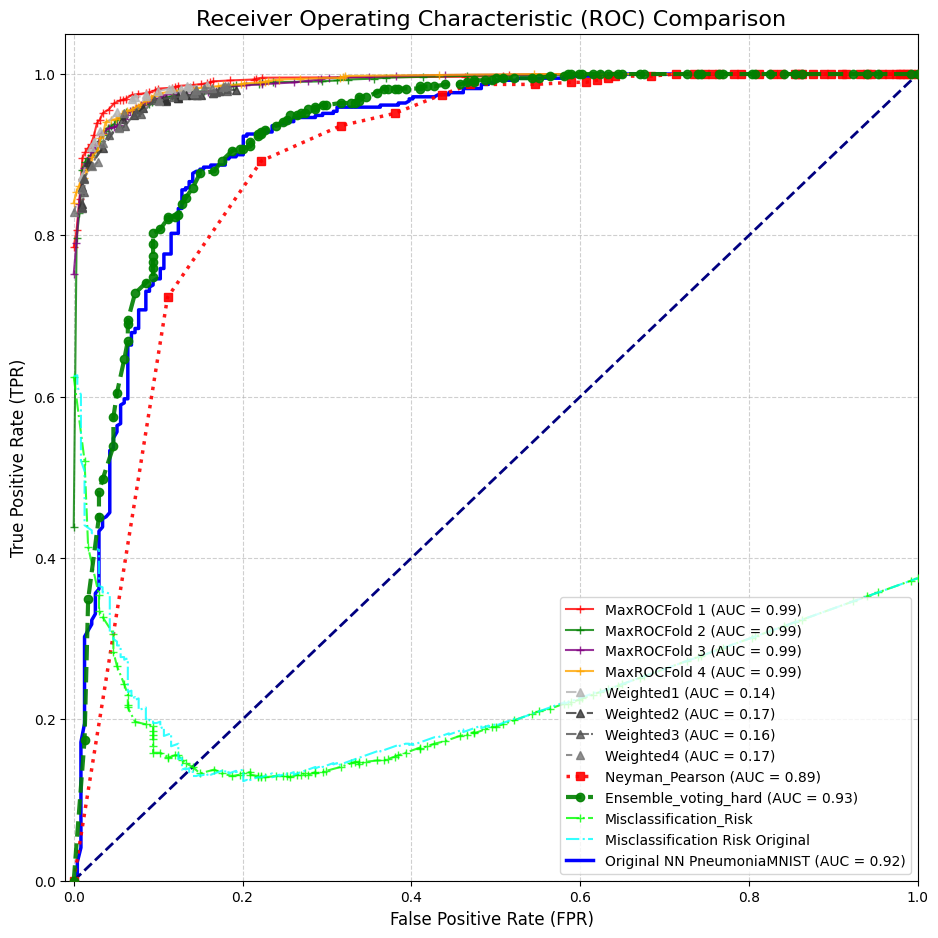

In [9]:

# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
results_lists.append(constrained_points)
results_lists.append(ensemble_results_hard)
results_lists.append(misclassification_risk)


# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    names=["MaxROCFold 1", "MaxROCFold 2", "MaxROCFold 3", "MaxROCFold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Neyman_Pearson", "Ensemble_voting_hard", "Misclassification_Risk"],
    results_original_roc=results_original_roc, plot_name="NN_oversample_PneumoniaMNIST", prior_prob=prior_proba
)